In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import json
from PIL import Image
from tqdm import tqdm
import random
import torchvision.transforms as transforms
# import custom_transforms as c_transforms

In [2]:
img_dir = '/home/syeda/VLR_Project/VLR/testVLR/image'
alpha_dir = '/home/syeda/VLR_Project/VLR/testVLR/masks'
seg_dir = '/home/syeda/VLR_Project/VLR/testVLR/cropped_segment_outputs'

img_file_names = sorted([f for f in os.listdir(img_dir)])
alpha_file_names = sorted([f for f in os.listdir(alpha_dir)])
seg_file_names = sorted([f for f in os.listdir(seg_dir) if f.endswith('.png')])
seg_file_names_color = sorted([f for f in os.listdir(seg_dir) if f.endswith('.jpg')])

img_file_names = [os.path.join(img_dir, file_name) for file_name in img_file_names]
alpha_file_names = [os.path.join(alpha_dir, file_name) for file_name in alpha_file_names]
seg_file_names = [os.path.join(seg_dir, file_name) for file_name in seg_file_names]
seg_file_names_color = [os.path.join(seg_dir, file_name) for file_name in seg_file_names_color]


In [3]:
img_file_names = sorted(img_file_names)
alpha_file_names = sorted(alpha_file_names)
seg_file_names = sorted(seg_file_names)
seg_file_names_color = sorted(seg_file_names_color)

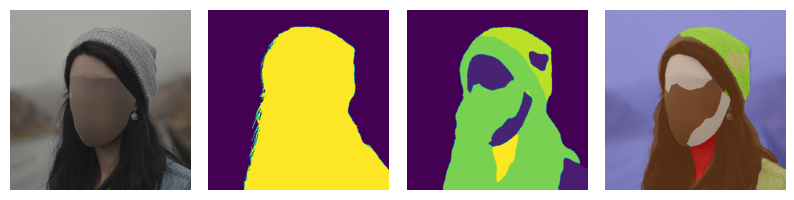

In [4]:
img_idx = 0

# # Path to the images
# image_paths = [
#     img_file_names[img_id],
#     alpha_file_names[img_id],
#     seg_file_names[img_id],
#     seg_file_names_color[img_id]
# ]

# img = mpimg.imread(image_paths[0])
# alpha = mpimg.imread(image_paths[1])
# # Converting to one channel mask
# alpha = cv2.cvtColor(alpha, cv2.COLOR_BGR2GRAY)
# # Creating alpha mask
# alpha_mask =  np.where(alpha*255 > 45, 255, 0)
 
# seg_mask = mpimg.imread(image_paths[2])
# seg_color_mask = mpimg.imread(image_paths[3])

def get_img_and_masks(index):
    img = mpimg.imread(img_file_names[index])
    alpha = mpimg.imread(alpha_file_names[index])
    alpha = cv2.cvtColor(alpha, cv2.COLOR_BGR2GRAY)
    alpha_mask =  np.where(alpha*255 > 45, 255, 0)
    seg_mask = mpimg.imread(seg_file_names[index])
    seg_color_mask = mpimg.imread(seg_file_names_color[index])

    # Resize alpha mask
    resized_img = cv2.resize(
        img.astype(np.uint8),
        seg_mask.shape[::-1],
        interpolation=cv2.INTER_CUBIC
        )
    resized_alpha_mask = cv2.resize(
        alpha_mask.astype(np.uint8),
        seg_mask.shape[::-1],
        interpolation=cv2.INTER_CUBIC
        )
    
    return resized_img, resized_alpha_mask, seg_mask, seg_color_mask

img, resized_alpha_mask, seg_mask, seg_color_mask = get_img_and_masks(img_idx)
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

axs[0].imshow(img)
axs[1].imshow(resized_alpha_mask)
axs[2].imshow(seg_mask)
axs[3].imshow(seg_color_mask)

for i in range(4):
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [5]:
# # Create hair mask
# hair_present = False
# for i in np.unique(seg_mask):
#     image_array_test = seg_mask.copy()
#     image_array_test_mono = np.where(image_array_test == i,1,0)
#     if abs(i - 0.784) < 0.001:
#         hair_mask = image_array_test_mono.copy()
#         hair_present = True
#         print('Hair Detected')
#         # plt.imshow(hair_mask, cmap='viridis')
#         # plt.show()
#     if not hair_present:
#         hair_mask = np.ones_like(image_array_test)

def create_hair_mask(seg_mask):
  hair_present = False
  for i in np.unique(seg_mask):
      image_array_test = seg_mask.copy()  
      image_array_test_mono = np.where(image_array_test == i,1,0)
      if abs(i - 0.784) < 0.001:
          hair_mask = image_array_test_mono.copy()
          hair_present = True
        #   print('Hair Detected')
          return hair_mask

  if not hair_present:
      hair_mask = np.ones_like(image_array_test)
      return hair_mask
  
hair_mask = create_hair_mask(seg_mask)

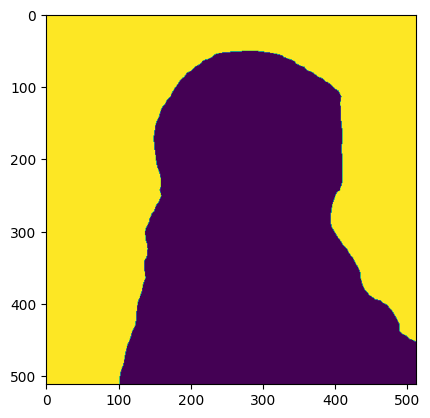

In [6]:
# # Create background mask
# for i in np.unique(seg_mask):
#     image_array_test = seg_mask.copy()
#     image_array_test_mono = np.where(image_array_test == i,1,0)
#     if abs(i - 0.0) < 0.001:
#         bkg_mask = image_array_test_mono.copy()
#         print('Bkg Detected')
#         plt.imshow(bkg_mask, cmap='viridis')
#         plt.show()
# # Change label of backgorund to 2 
# bkg_mask = np.where(bkg_mask==1,2,bkg_mask)

def create_bkg_mask(seg_mask, plot=False):

  for i in np.unique(seg_mask):
      image_array_test = seg_mask.copy()   
      image_array_test_mono = np.where(image_array_test == i,1,0)

      if abs(i - 0.0) < 0.001:
          bkg_mask = image_array_test_mono.copy()
          # print('Bkg Detected')
  
  if plot:
    plt.imshow(bkg_mask)
    plt.show()
        
  # Change label of background to 2        
  bkg_mask = np.where(bkg_mask==1,2,bkg_mask)
  
  return bkg_mask

bkg_mask = create_bkg_mask(seg_mask, plot=True)  

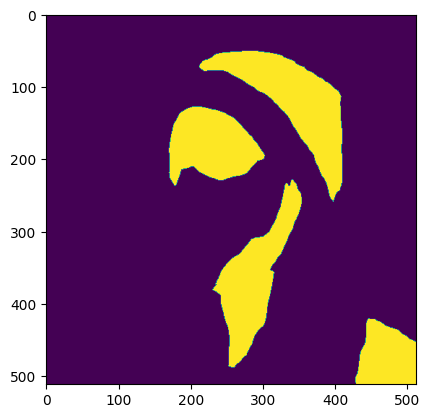

In [7]:
# # Create rest_of_human mask
# roh_mask = np.zeros_like(seg_mask)

# for i in np.unique(seg_mask):
#     image_array_test = seg_mask.copy()
#     # image_array_test_mono = np.where(image_array_test == i,1,0)
#     if abs(i - 0.0) < 0.001 or abs(i - 0.784) < 0.001:
#         continue
#     roh_mask =  np.where(image_array_test == i,1,roh_mask)
# plt.imshow(roh_mask)
# plt.show()

def create_roh_mask(seg_mask, plot=False):

  roh_mask = np.zeros_like(seg_mask)

  for i in np.unique(seg_mask):
      image_array_test = seg_mask.copy()   
      if abs(i - 0.0) < 0.001 or abs(i - 0.784) < 0.001:
          continue
      roh_mask =  np.where(image_array_test == i,1,roh_mask)

  if plot:
      plt.imshow(roh_mask)
      plt.show()
          
  return roh_mask

roh_mask = create_roh_mask(seg_mask, plot=True)

In [8]:
# # Define the kernel (structuring element) for dilation
# dilation_factor = 40
# kernel = np.ones((dilation_factor, dilation_factor), np.uint8)  # Square kernel of size 5x5

# # Perform dilation
# dilated_mask = cv2.dilate(hair_mask.astype(np.uint8), kernel, iterations=1)

# # Create combined mask with boolean
# combined_hair_mask = cv2.bitwise_and(dilated_mask, resized_alpha_mask)
# combined_hair_mask = np.where(roh_mask==1,0,combined_hair_mask)


# # Find contours to clean the mask
# contours, _ = cv2.findContours(combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Find the largest contour by area
# largest_contour = max(contours, key=cv2.contourArea)

# # Create a new mask with only the largest contour
# final_mask = np.zeros_like(combined_hair_mask)
# cv2.drawContours(final_mask, [largest_contour], 0, 255, -1)
# final_combined_hair_mask = cv2.bitwise_and(combined_hair_mask, final_mask)

def get_final_hair_mask(hair_mask, resized_alpha_mask, roh_mask):

  # Define dilation kernel
  dilation_factor = 40
  kernel = np.ones((dilation_factor, dilation_factor), np.uint8)  

  # Dilate hair mask
  dilated_mask = cv2.dilate(hair_mask.astype(np.uint8), kernel, iterations=1)

  # Combine with alpha mask  
  combined_hair_mask = cv2.bitwise_and(dilated_mask, resized_alpha_mask)
  
  # Filter out rest of human  
  combined_hair_mask = np.where(roh_mask==1,0,combined_hair_mask)

  # Find contours  
  contours, _ = cv2.findContours(combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Get largest contour  
  largest_contour = max(contours, key=cv2.contourArea)

  # Create mask from contour
  final_mask = np.zeros_like(combined_hair_mask)
  cv2.drawContours(final_mask, [largest_contour], 0, 255, -1)

  # Return final mask
  final_combined_hair_mask = cv2.bitwise_and(combined_hair_mask, final_mask)
  return final_combined_hair_mask, dilated_mask, combined_hair_mask

final_combined_hair_mask, dilated_mask, combined_hair_mask = get_final_hair_mask(hair_mask, resized_alpha_mask, roh_mask)

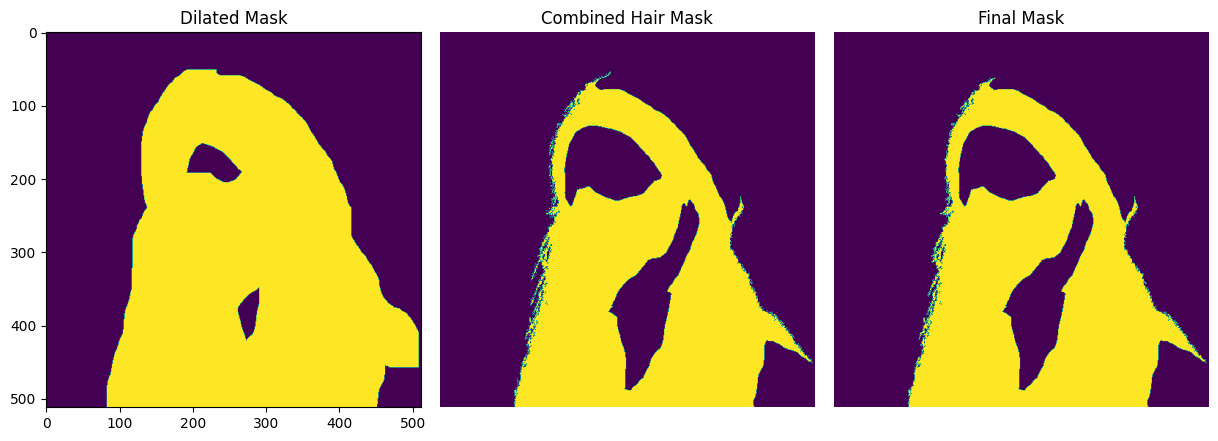

In [9]:
# Plot Final Masks
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].imshow(dilated_mask)
axs[0].set_title("Dilated Mask")

axs[1].imshow(combined_hair_mask)
axs[1].set_title("Combined Hair Mask")

axs[2].imshow(final_combined_hair_mask)
axs[2].set_title("Final Mask")

# Remove the axis labels
for ax in axs[1:]:
    ax.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.show()

[0 1 2 3]


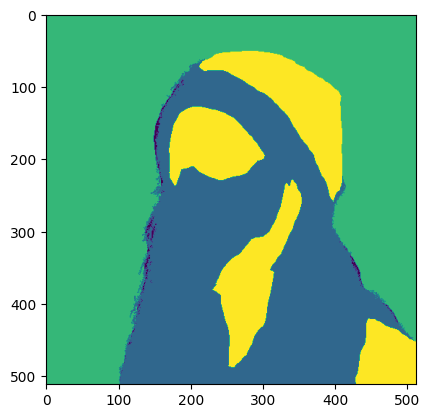

In [10]:
mask_for_patch_filtering = np.where(final_combined_hair_mask==1, 1, bkg_mask)
mask_for_patch_filtering = np.where(roh_mask==1, 3, mask_for_patch_filtering)

plt.imshow(mask_for_patch_filtering)
print(np.unique(mask_for_patch_filtering))

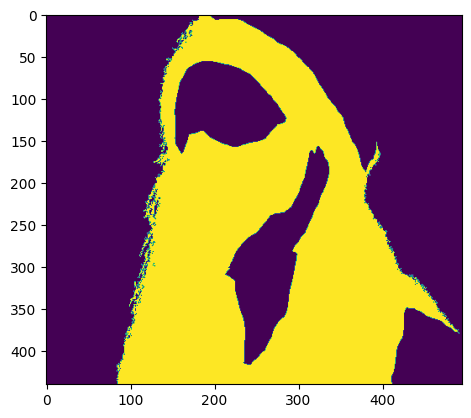

In [11]:
# # Find the contours in the mask
# contours, _ = cv2.findContours(final_combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Find the largest contour by area
# largest_contour = max(contours, key=cv2.contourArea)

# # Calculate the centroid (center of mass) of the largest contour
# M = cv2.moments(largest_contour)
# if M["m00"] != 0:
#     cx = int(M["m10"] / M["m00"])
#     cy = int(M["m01"] / M["m00"])
# else:
#     # Set centroid to (0, 0) if the moment is 0
#     cx, cy = 0, 0

# crop_size = 512

# x1 = max(0, cx - crop_size // 2)
# x2 = min(resized_alpha_mask.shape[1], cx + crop_size // 2)
# y1 = max(0, cy - crop_size // 2)
# y2 = min(resized_alpha_mask.shape[0], cy + crop_size // 2)

# cropped_mask = final_combined_hair_mask[y1:y2, x1:x2]

def get_crop_coords(final_combined_hair_mask):

  # Find contours
  contours, _ = cv2.findContours(final_combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find largest contour
  largest_contour = max(contours, key=cv2.contourArea)

  # Calculate centroid
  M = cv2.moments(largest_contour)
  if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])  
      cy = int(M["m01"] / M["m00"])
  else:
      cx, cy = 0, 0

  crop_size = 512

  # Calculate crop coordinates
  x1 = max(0, cx - crop_size//2)
  x2 = min(final_combined_hair_mask.shape[1], cx + crop_size//2)
  y1 = max(0, cy - crop_size//2) 
  y2 = min(final_combined_hair_mask.shape[0], cy + crop_size//2)

  return x1, x2, y1, y2

x1, x2, y1, y2 = get_crop_coords(final_combined_hair_mask)
cropped_mask = final_combined_hair_mask[y1:y2, x1:x2]
cropped_mask_for_filtering = mask_for_patch_filtering[y1:y2, x1:x2]

plt.imshow(cropped_mask)
plt.show()

In [12]:
img.shape

(512, 512, 3)

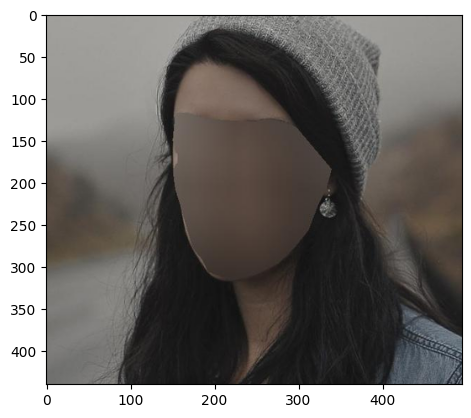

In [13]:
cropped_img = img.copy()[y1:y2, x1:x2,:]
plt.imshow(cropped_img)

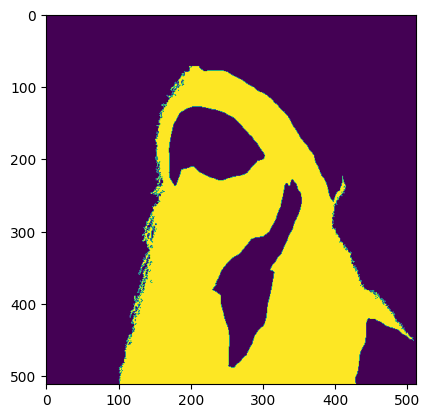

In [14]:
# Pasting cropped image back onto original image
larger_image = Image.fromarray(np.zeros_like(combined_hair_mask))
smaller_image = Image.fromarray(cropped_mask)

larger_image.paste(smaller_image, (x1, y1))
plt.imshow(larger_image)

In [15]:
# Experimenting with patching

# # Resizing to make it a square
# resized_cropped_mask = cv2.resize(cropped_mask, (512, 512), interpolation = cv2.INTER_NEAREST)
# resized_cropped_mask_for_filtering = cv2.resize(cropped_mask_for_filtering, (512, 512), interpolation = cv2.INTER_NEAREST)

# # Get the dimensions of the image
# height, width = resized_cropped_mask.shape

# # Define the number of patches
# num_patches = 64  # Change this value as needed

# # Calculate the size of each patch
# patch_size = int(width / np.sqrt(num_patches))

# # Initialize an empty list to store the patches
# patches = []
# filtered_patches = []
# patch_map = np.zeros((int(num_patches**0.5), int(num_patches**0.5)))
# patch_map_linear = []

# idx = 0
# # Loop over the image and extract patches
# for i in range(0, height, patch_size):
#     for j in range(0, width, patch_size):
#         patch = resized_cropped_mask[i:i+patch_size, j:j+patch_size]
#         patch_inspect = resized_cropped_mask_for_filtering[i:i+patch_size, j:j+patch_size]
#         patches.append(patch)
#         unique = np.unique(patch_inspect)
#         if len(unique)>1 and 1 in unique and 2 in unique:
#             num_matches = (patch_inspect==3).sum()
#             fraction = num_matches / patch.size
#             # Filtering patches with more than 30% of rest classes
#             if fraction < 0.3:
#                 filtered_patches.append(patch)
#                 # print(j//patch_size, i//patch_size)
#                 patch_map[j//patch_size][i//patch_size] = 1
#                 patch_map_linear.append(idx)
#         idx += 1

def get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering):

    resized_cropped_mask = cv2.resize(cropped_mask, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_mask_for_filtering = cv2.resize(cropped_mask_for_filtering, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_img = cv2.resize(cropped_img, (512, 512), interpolation = cv2.INTER_NEAREST)
    # Get image dimensions
    height, width = resized_cropped_mask.shape

    # Set number of patches
    num_patches = 64

    # Calculate patch size  
    patch_size = int(width / np.sqrt(num_patches))

    # Initialize empty lists
    patches = [] 
    filtered_patches = []
    patch_map_linear = []
    img_patches = []

    idx = 0
    # Loop over image and extract patches  
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):

            patch = resized_cropped_mask[i:i+patch_size, j:j+patch_size]
            patch_inspect = resized_cropped_mask_for_filtering[i:i+patch_size, j:j+patch_size]
            img_patch = resized_cropped_img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            img_patches.append(img_patch)

            unique = np.unique(patch_inspect)

            if len(unique)>1 and 1 in unique and 2 in unique:
                num_matches = (patch_inspect==3).sum()
                fraction = num_matches / patch.size
                
                if fraction < 0.3: 
                    filtered_patches.append(patch)  
                    patch_map_linear.append(idx)

            idx += 1

    return img_patches, patches, filtered_patches, patch_map_linear

img_patches, patches, filtered_patches, patch_map_linear = get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering)
print(len(patches), len(filtered_patches))
print(patch_map_linear)

64 12
[2, 25, 26, 30, 33, 34, 38, 41, 46, 47, 49, 57]


(64, 64)


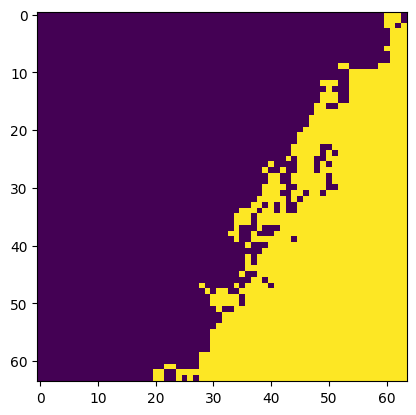

(64, 64)


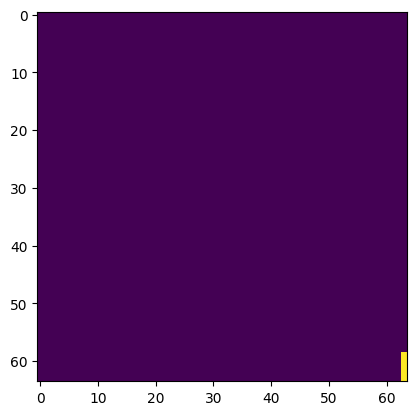

(64, 64)


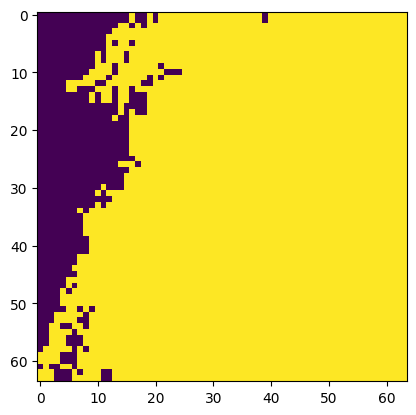

(64, 64)


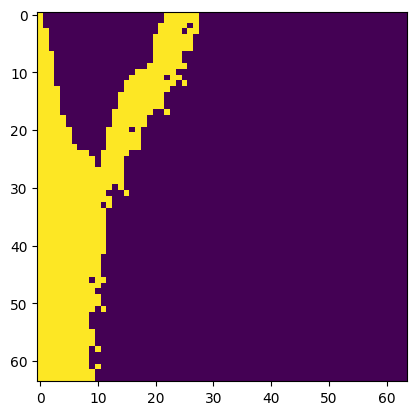

(64, 64)


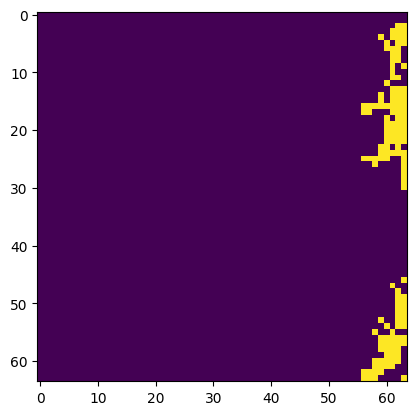

(64, 64)


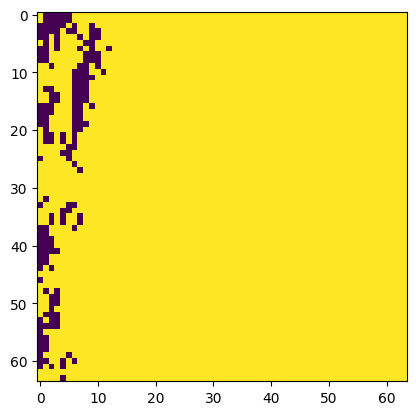

(64, 64)


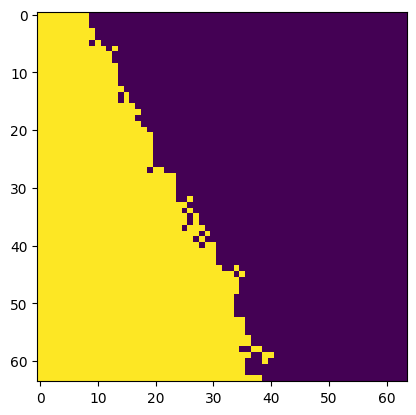

(64, 64)


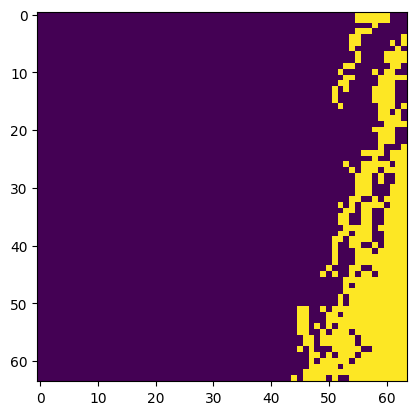

(64, 64)


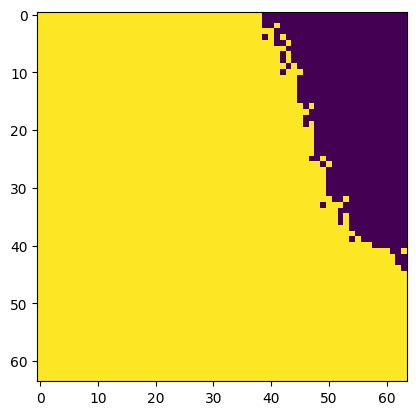

(64, 64)


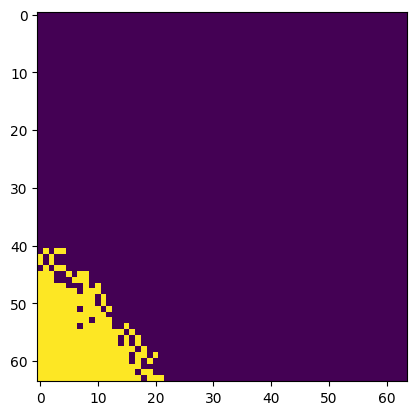

(64, 64)


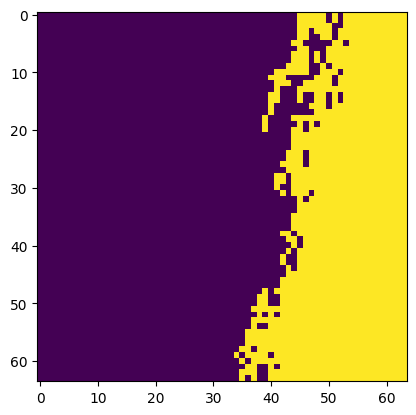

(64, 64)


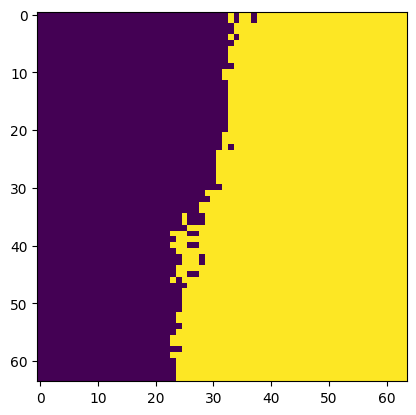

In [16]:
for p in filtered_patches:
    plt.imshow(p)
    print(p.shape)
    plt.show()

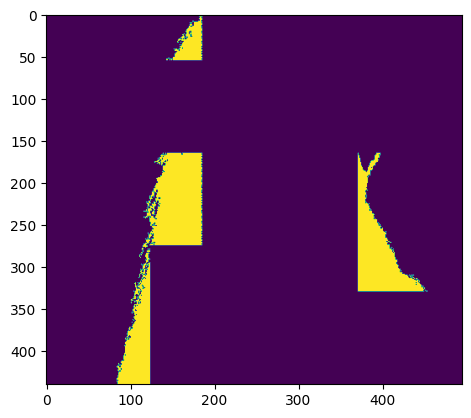

In [17]:
def combine_patches(patches, patches_per_row, total_patches, only_filtered_patches=False):
    # Calculate the number of rows
    num_rows = total_patches // patches_per_row
    
    # Get the dimensions of the first patch
    patch_height, patch_width = patches[0].shape
    
    # Create a new array with the combined dimensions
    combined_width = patch_width * patches_per_row
    combined_height = patch_height * num_rows
    combined_image = np.zeros((combined_height, combined_width), dtype=patches[0].dtype)
    
    if only_filtered_patches: 
        # Iterate over the filtered patches and place them into the combined image
        for i, patch in enumerate(filtered_patches):
            idx = patch_map_linear[i]
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    else:
        # Iterate over the patches and place them into the combined image
        for idx, patch in enumerate(patches):
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    
    return combined_image

# Combine the patches into a single image
combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=True)
combined_image.shape

plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))

In [18]:
img.shape, seg_mask.shape, cropped_mask.shape, patch_map_linear, 

((512, 512, 3),
 (512, 512),
 (440, 495),
 [2, 25, 26, 30, 33, 34, 38, 41, 46, 47, 49, 57])

In [19]:
# Create data dict

data_dict = dict(
    original_image_size = img.shape,
    seg_mask_size = seg_mask.shape,
    cropped_mask_size = cropped_mask.shape,
    patch_map_linear = patch_map_linear,
    patch_coords = [x1, x2, y1, y2],
    patch_coords_format = 'x1, x2, y1, y2',
)

In [20]:
# Get list of all images and masks
# Sort them identically
# loop over the len of list and get the various masks and apply the operations with the functions defined here to get the inter,ediate masks
# and the final patches along with the metadata
# Save the mask patches as pngs and image patches as jpgs with one json file to carry information, all in a folder with the name of the image 

In [21]:
data_dict

{'original_image_size': (512, 512, 3),
 'seg_mask_size': (512, 512),
 'cropped_mask_size': (440, 495),
 'patch_map_linear': [2, 25, 26, 30, 33, 34, 38, 41, 46, 47, 49, 57],
 'patch_coords': [17, 512, 72, 512],
 'patch_coords_format': 'x1, x2, y1, y2'}

In [22]:
img_dir = '/home/syeda/VLR_Project/VLR/testVLR/images'
alpha_dir = '/home/syeda/VLR_Project/VLR/testVLR/masks'
seg_dir = '/home/syeda/VLR_Project/VLR/testVLR/cropped_segment_outputs'

img_file_names = sorted([f for f in os.listdir(img_dir)])
alpha_file_names = sorted([f for f in os.listdir(alpha_dir)])
seg_file_names = sorted([f for f in os.listdir(seg_dir) if f.endswith('.png')])
seg_file_names_color = sorted([f for f in os.listdir(seg_dir) if f.endswith('.jpg')])

img_file_names = [os.path.join(img_dir, file_name) for file_name in img_file_names]
alpha_file_names = [os.path.join(alpha_dir, file_name) for file_name in alpha_file_names]
seg_file_names = [os.path.join(seg_dir, file_name) for file_name in seg_file_names]
seg_file_names_color = [os.path.join(seg_dir, file_name) for file_name in seg_file_names_color]


In [26]:
for img_idx in range(len(img_file_names[:])):
    print(f"\r{img_idx}/{len(img_file_names)}", end=" ")
    try: 
        data_dict = dict()
        resized_img, resized_alpha_mask, seg_mask, seg_color_mask = get_img_and_masks(img_idx)
        hair_mask = create_hair_mask(seg_mask)
        bkg_mask = create_bkg_mask(seg_mask, plot=False)  
        roh_mask = create_roh_mask(seg_mask, plot=False)

        final_combined_hair_mask, dilated_mask, combined_hair_mask = get_final_hair_mask(hair_mask, resized_alpha_mask, roh_mask)
        mask_for_patch_filtering = np.where(final_combined_hair_mask==1, 1, bkg_mask)
        mask_for_patch_filtering = np.where(roh_mask==1, 3, mask_for_patch_filtering)

        x1, x2, y1, y2 = get_crop_coords(final_combined_hair_mask)
        cropped_mask = final_combined_hair_mask[y1:y2, x1:x2]
        cropped_mask_for_filtering = mask_for_patch_filtering[y1:y2, x1:x2]
        cropped_img = resized_img.copy()[y1:y2, x1:x2]

        img_patches, patches, filtered_patches, patch_map_linear = get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering)
        # print(len(patches), len(filtered_patches))

        data_dict = dict(
            img_idx = img_idx,
            original_image_size = img.shape,
            seg_mask_size = seg_mask.shape,
            cropped_mask_size = cropped_mask.shape,
            patch_map_linear = patch_map_linear,
            patch_coords = [x1, x2, y1, y2],
            patch_coords_format = 'x1, x2, y1, y2',
            )
        
        folder_name = os.path.basename(img_file_names[img_idx])[:-4]
        patch_folder_path = '/home/syeda/VLR_Project/VLR/testVLR/patch_folder'
        save_folder_path = os.path.join(patch_folder_path, folder_name)
    except:
        continue
    
    # Create a new folder if it doesn't exist
    # if not os.path.exists(save_folder_path):
    #     os.makedirs(save_folder_path)

    for idx in patch_map_linear:
        img_patch = img_patches[idx]
        patch = patches[idx]
        patch_path = save_folder_path + f'/{idx}.png'
        img_patch_path = save_folder_path + f'/{idx}.jpg'
        json_path = save_folder_path + f'/data_dict.json'
        if len(data_dict['patch_map_linear']) < 5:
            continue
        try:
            if not os.path.exists(save_folder_path):
                os.makedirs(save_folder_path)
            cv2.imwrite(patch_path, patch*255)
            cv2.imwrite(img_patch_path, img_patch)

            with open(json_path, 'w') as json_file:
                json.dump(data_dict, json_file, indent=4)
        except:
            continue
    
    # combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=True)
    # plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))
    # plt.show()
    # combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=False)
    # plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))
    # plt.show()
    




5355/5356 

In [24]:
class CustomDataloader(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    def __init__(self, path_dict, batch_size, shuffle=True, augmentation=False):

        self.og_img_files = path_dict['og_img_files']
        self.patch_folder = path_dict['patch_folder']
        self.batch_size   = batch_size
        self.shuffle      = shuffle
        self.augmentation = augmentation 

        #  pre-processing
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        self.trans_train_main = c_transforms.Compose([
            c_transforms.HorizontalFlip(),
            c_transforms.RandomRotate(degrees=(-15,15)),
            # c_transforms.RandomScale((0.75, 1.0, 1.25, 1.5, 1.75, 2.0)),
            # c_transforms.RandomCrop(cropsize)
            ])
        self.trans_train_colors = transforms.Compose([
            transforms.ColorJitter(
                brightness=0.3,
                contrast=0.3,
                saturation=0.3),
            transforms.RandomGrayscale(p=0.2),
                ])


        # Each image gets split into sub images to form one training batch
        self.num_batches =  len(os.listdir(self.og_img_files))    

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        return self.num_batches

    def __iter__(self):
        data_dict = {}
        batch_idx = 0

        patch_folders = os.listdir(self.patch_folder)
        
        if self.shuffle:
            random.shuffle(patch_folders)

        # patch_names = ([f for f in os.listdir(patch_folders)])
        patch_paths = [os.path.join(self.patch_folder, file_name) for file_name in patch_folders]
        
        while batch_idx < self.num_batches:
            img_patches = sorted([os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.jpg')])
            mask_patches = sorted([os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.png')])
            data_dict_path = [os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.json')]
            
            with open(data_dict_path[0]) as json_file:
                data_dict = json.load(json_file)
            img_batch = []
            mask_batch = []
            for i in range(len(img_patches)):
                img = mpimg.imread(img_patches[i])
                mask = mpimg.imread(mask_patches[i])

            
                if not self.augmentation:
                    augmented_img = self.to_tensor(img)
                    augmented_mask= self.to_tensor(mask)
                else:
                    img = Image.fromarray(img)
                    mask = Image.fromarray(mask)
                    im_lb = dict(im=img, lb=mask)
                    im_lb = self.trans_train_main(im_lb)
                    im_lb['im'] = self.trans_train_colors(im_lb['im'])

                    augmented_img, augmented_mask = im_lb['im'], im_lb['lb']
                    
                    augmented_img = self.to_tensor(np.array(augmented_img))
                    augmented_mask= self.to_tensor(np.array(augmented_mask))
            
            # APPLY AUGMENTATIONS FOLLOWED BY YIELDING
                img_batch.append(augmented_img)
                mask_batch.append(augmented_mask)

            batch_idx += 1
            yield data_dict, img_batch, mask_batch

In [25]:
path_dict = {
"og_img_files" : '/home/syeda/VLR/testVLR/images',
"patch_folder" : '/home/syeda/VLR/testVLR/patch_folder',
}

# Some sanity checks
dl = CustomDataloader(
    path_dict     = path_dict,
    batch_size  = 16,
    shuffle     = False,
    augmentation=True,
)

d, inputs, targets = next(iter(dl))
# print(inputs.shape, targets.shape)

for d, x, y in dl:

    plt.imshow(x[10].permute(1, 2, 0).numpy())
    plt.show()
    plt.imshow(y[10].permute(1, 2, 0).numpy())
    plt.show()
    print(d)
    break

NameError: name 'c_transforms' is not defined